# What is lost when intentionally removing  'difficult' data?

When examining the raw FracFocus data from the bulk download, it becomes obvious that many records in critical fields are empty, have inconsistent values or contain minor to severe typographical errors.  I believe that the presense of this difficult data is one of the primary reasons the FracFocus data are seldom used: they are considered too complex to deal with or too dirty to trust.

In this Proof-of-Concept version, I intentionally filter data in the raw FracFocus download that requires either many assumptions or complex decisions. While in other versions of this code I have tried to grapple with the complexity and inherent inconsistencies of the whole FracFocus set, I hope to show in this version that filtering much of the difficult data still leaves us with a very useful data set.  However, it is important to investigate to what degree this filtering may obscure or bias actual fracking practice documented by the whole FracFocus collection.  

In this analysis notebook, I show the types and quantities of data that I have removed from the raw data to make processing 'simple.'  I examine the major sources of filtering: removing 'empty' events, removing events with duplicates, removing chemical records that are poorly identified, and ignoring records in which the carrier is poorly identified.  I also outline some ways that the code and analysis can be improved to include more of the raw data.

This notebook uses a data set generated by a Python code project (and the code to produce the analysis is integrated here).  The raw source data (the Excel version) was downloaded from FracFocus.org on June 25, 2019.  

### Some terminology
What I call 'events' are distinct fracking events that are typically documented by a single disclosure with a list of  chemicals/materials used in the fracturing process (these are separate from the chemicals used to *drill* the well which are not covered by FracFocus). Each event is identified in the raw data by a unique code in the UploadKey field.  All records with a given UploadKey will have the same Start and End Dates, location, etc.  If you are familiar with the individual pdf files available at FracFocus.org, each pdf file corresponds to one event and one unique UploadKey.

In [2]:
# Code preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


results_dir = './out/'      # for local use
#results_dir = '../results/' # for CodeOcean

In [3]:
# pull data from the results directory where it is stored as a .csv file
# we don't need all the colunms 
cols = ['UploadKey','date','CASNumber','bgCAS','record_flags','FFVersion']
df = pd.read_csv(results_dir+'full_df.csv',low_memory=False) 
df.date = pd.to_datetime(df.date)  # put date back into pandas datetime format
df['year'] = df.date.dt.year  # create 'year' variable

# Removing 'empty' events

## Background
Although FracFocus began recording chemical disclosures in 2011 and making them available through the pdf files that year, most of the chemical records for the events in these early years are not included in the bulk download.  Instead, placeholder records are used for those events.  Included in these placeholders are location data, dates, and often drilling depth and water volumes used but **no** chemical information.

I flag these events and they are removed for analysis. 


## Number of empty events

In [3]:
gb = df[(df.year>2009)&(df.year<2020)].groupby('UploadKey',as_index=False)['date','year','record_flags','FFVersion'].first() # only need one record from each event
gb['empty_event'] = gb.record_flags.str.contains('1') # record_flags of '1' indicates no chemical records
gb['not_empty'] = ~gb.empty_event
print(f'Total number of events: {len(gb)}, number of empty: {gb.empty_event.sum()}')

Total number of events: 159492, number of empty: 43897


## Empty events are largely from 2011 to 2013

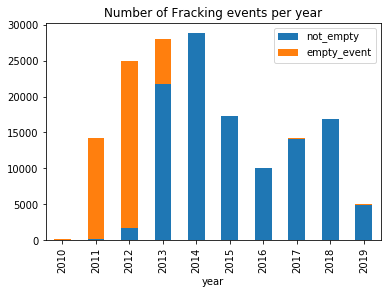

In [4]:
gb2 = gb.groupby('year',as_index=False)['empty_event','not_empty'].sum()
gb2.plot.bar(x='year',y=['not_empty','empty_event'],stacked=True,title="Number of Fracking events per year");


## ... and are FFVersion 1

In [5]:
print('Number of empty events that are:')
for i in [1,2,3]:
    print(f'  FFVersion {i}: {gb[gb.FFVersion==i].empty_event.sum()}')

Number of empty events that are:
  FFVersion 1: 43813
  FFVersion 2: 6
  FFVersion 3: 78


## Possible improvements

The technical manager of FracFocus communicated to me that the chemical data in FFVersion 1 is of lower quality than more recent versions.  That low quality was the reason they chose to not include it with the bulk download.  Nevertheless, those data cover an important 'boom' time in the fracking industry and may be of interest to many researchers. 

Therefore, be aware that data for many of these early events was scraped from pdfs (through tremdendous effort) by the SkyTruth team during 2011-2013 and are still available at their [website](http://frack.skytruth.org/fracking-chemical-database/frack-chemical-data-download).  In other versions of my code, I have integrated these data. However, for simplicity sake in this Proof-of-Concept version, we process only what is presented by FracFocus in their official bulk download.



# Removing duplicated events

## Background
For a given APINumber, there may be multiple fracking events in the raw data.  Some of these are events that occur on different dates which indicates actual multiple fracks.  However, many other duplicates in the raw data have the **same date**.  Because there is more than one possible cause for this duplication (e.g., operators *adding* to a previous disclosure, operators *replacing* a previous disclosure) and there is no indication in the data which cause is operating, I choose to filter out ALL disclosures related to duplicated events.  

## Duplicates are a small percentage of all events and distributed across all years

In [6]:
gb = df[(df.year>2009)&(df.year<2020)].groupby(['date','api10'],as_index=False)['record_flags'].first() # only need one record from each event
print(f'Number of unique API/dates: {len(gb)}')
print(f'Number of unique API/dates involved with duplication: {len(gb[gb.record_flags.str.contains("2")])}')

gb = df[(df.year>2009)&(df.year<2020)].groupby('UploadKey',as_index=False)['year','record_flags','FFVersion',
                                                          'bgOperatorName','bgSupplier'].first() # only need one record from each event
gb['dup_event'] = gb.record_flags.str.contains('2') # record_flags of '2' indicates one of a duplicated event
gb['not_duplicated'] = ~gb.dup_event
print(f'Total number of duplicates: {gb.dup_event.sum()}')



Number of unique API/dates: 156762
Number of unique API/dates involved with duplication: 2267
Total number of duplicates: 4700


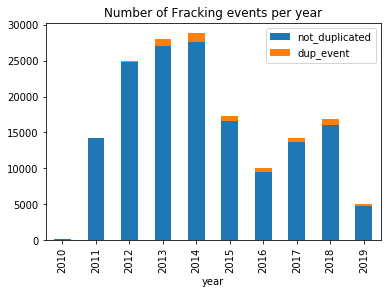

In [7]:
gb2 = gb.groupby('year',as_index=False)['dup_event','not_duplicated'].sum()
gb2.plot.bar(x='year',y=['not_duplicated','dup_event'],stacked=True,title="Number of Fracking events per year");


## are some Operators more likely to submit duplicates?
which might indicate that my filtered set is biased...

In [8]:
opNum = df.groupby('bgOperatorName',as_index=False)['UploadKey'].count()
opNum.columns = ['bgOperatorName','total_frack_count']
gb2 = gb[gb.dup_event].groupby('bgOperatorName',as_index=False)['UploadKey'].count()
gb2.columns = ['bgOperatorName','duplicated_frack_count']
gb2 = pd.merge(gb2,opNum,on='bgOperatorName',how='left')
gb2['percent_dups'] = gb2.duplicated_frack_count/gb2.total_frack_count *100
gb2.sort_values('duplicated_frack_count',ascending=False).head(20)

,bgOperatorName,duplicated_frack_count,total_frack_count,percent_dups
82,devon energy production company l. p.,264,123138,0.214394
216,pdc energy,164,42159,0.389004
98,endeavor energy resources,161,19206,0.838280
67,conocophillips company/burlington resources,149,108781,0.136972
207,occidental oil and gas,125,123618,0.101118
65,cog operating llc,116,60345,0.192228
13,apache corporation,108,92582,0.116653
147,hunt oil company,106,20859,0.508174
203,"noble energy, inc.",104,60219,0.172703
11,anadarko petroleum corporation,103,144222,0.071418


## ...  or Suppliers?

In [9]:
opNum = df.groupby('bgSupplier',as_index=False)['UploadKey'].count()
opNum.columns = ['bgSupplier','total_frack_count']
gb2 = gb[gb.dup_event].groupby('bgSupplier',as_index=False)['UploadKey'].count()
gb2.columns = ['bgSupplier','duplicated_frack_count']
gb2 = pd.merge(gb2,opNum,on='bgSupplier',how='left')
gb2['percent_dups'] = gb2.duplicated_frack_count/gb2.total_frack_count *100
gb2.sort_values('duplicated_frack_count',ascending=False).head(20)

,bgSupplier,duplicated_frack_count,total_frack_count,percent_dups
132,no supplier reported,1014,754565,0.134382
0,_empty_entry_,440,623517,0.070567
95,halliburton,314,403437,0.077831
46,chemplex,281,174464,0.161065
20,baker hughes,210,235449,0.089191
169,schlumberger,198,294548,0.067222
137,operator,161,61881,0.260177
110,liberty,111,57924,0.191630
129,nabors completion and production services,89,109824,0.081039
75,economy polymers,75,40711,0.184225


## Possible improvements
While removing all disclosures related to duplicated events is the simplest to implement, it may be possible to detect which versions are the most recently added (perhaps by the order of records in the raw data).  However, the technical manager of FracFocus, Mark Layne, indicated to me that there were no clear ways to determine the cause of the duplication.  

# Filtering poorly identified chemical records

## Background
The primary identifier of a chemical material in the raw data is the CAS Registration Number. The FracFocus website points out the while an IngredientName is reported on most chemical records, such names are not as reliable as the CAS number.  There are often many synonyms for a given material and are often spelled in several ways in the raw data.  CAS numbers, however, are considered an authoritative identification and should apply across the entire data set.  Two examples: 7732-18-5 is water and 91-20-3 is naphthalene.

While the CASNumber field in the raw data is a much more reliable identifier, I have found many issues with its use in FracFocus. These problems include typographical errors, extraneous characters and poor formatting (CAS numbers have a strict format). For example, some records that are clearly water are mistakenly labled '7332-18-5'.  There are methods to detect and correct these problems (see Possible Improvements below), but for this proof-of-concept version I use a simple approach:  1) Clean the field of extraneous characters, 2) coerce the cleaned CAS number to the proper format (with some simple assumptions) and 3) check this against a catelog of known authoritative CAS numbers.  This catelog was created by running all unique CAS values in the data set through the online resource [SciFinder](https://scifinder.cas.org) (owned by Chemical Abstracts, the same company that registers CAS numbers).  SciFinder rejects any malformed CAS numbers but provides definitive identity to well-formed numbers.  

So, for this version, a FracFocus CAS number must exactly match (after cleaning) a definitive CAS number to be included in my final data set.  These exact matches are given the authoritative number and names (as bgCAS and bgIngredientName). The ingredient names I report (bgIngredientName) is the 'primary' name given by SciFinder for that CAS Number.  In most cases, SciFinder lists many acceptable synonyms.  There are many online resources to learn more about these chemicals including SciFinder (requires expensive subscription), PubChem and others.  Unfortunately, the free resources do not have all of the chemicals found in FracFocus.

In the process of categorizing these CAS numbers, I also flag entries of other types:
- proprietary 
- CAS like, but unrecognized by SciFinder
- not CAS-like
- duplicate record due within an event



In [10]:
df['perfect_match'] = df.record_flags.str.contains('P') # record_flags of 'P' indicates a perfect match with an authoritative id
df['proprietary'] = df.record_flags.str.contains('3') # record_flags of '3' indicates a match with a list of proprietay labels
df['not_kept'] = ~((df.perfect_match)|(df.proprietary))


In [ ]:
gb2 = df[(df.year>2009)&(df.year<2020)].groupby('year',as_index=False)['perfect_match','proprietary','not_kept'].sum()
gb2.plot.bar(x='year',y=['perfect_match','proprietary','not_kept'],stacked=True,title="Number of chemical records per year");


## Possible improvements
CAS numbers that do not perfectly match the CAS authority can sometimes differ because of a simple typographical error. In a different version of this code, I developed error checking and correcting techniques that integrated both the CASNumber and the reported ingredient name.  This involved a combination of automated checking and manual curation and significantly complicated the code.  For many chemical materials, this process improved inclusion by 1-5% and may be useful for specific chemicals of interest that have many labelling problems.  In general however, there we no huge improvements with this extra code.


# Filtering events with poorly identified carriers

## Background
The chemical records that are identified by exact matches to the CAS authority give a broad picture of what chemicals are typically used in the industry, where they are used and by whom.  For these types of questions, simple 'presence/absence' may be enough.  However, measures of the actual quantities of the chemicals is much more informative.  The FracFocus data have hooks that allow such calculations and, although the pdf version doesn't provide it, the bulk download version has a MassIngredient field.  Unfortunately, this field reports no data or zeros or is inconsistent with other numbers in a large proportion of the data. 

To overcome this major weakness, I calculate mass using simple relationships among the total base water volume, the fraction of that water to the whole fracking mass, and the fraction of individual chemicals in the whole mass.  My calculations align with the reported mass (when available).  However, for this version of the code, I restrict these calculations to events where the following criteria are met:
- Water is the principle carrier (that is, some events record a petroleum product as carrier)
- The carrier record can be reliably identified and there is only a single record in the event (I require that it is water, and >40% of the total fracking mass).
- The fraction for the carrier is given (in PercentHFJob)
- The fraction of the chemical of interest is given.  (also PercentHFJob)
- The sum of PercentHFJob for the entire event is within a 5% tolerance of 100% (for many events, total percentage is out of tolerance)


In [ ]:
df['mass_avail'] = df.record_flags.str.contains('M')
df['presence_avail'] = (df.record_flags.str.contains('A'))&(~df.mass_avail)
df['not_avail'] = ~(df.mass_avail|df.presence_avail)
gb2 = df[(df.year>2009)&(df.year<2020)].groupby('year',as_index=False)['mass_avail','presence_avail','not_avail'].sum()
gb2.plot.bar(x='year',y=['mass_avail','presence_avail','not_avail'],stacked=True,title="Number of chemical records per year");


Note that included in the mass_avail and presence_avail categories are records that are identified as 'Proprietary'.


In [ ]:
p = df.not_avail.sum()/len(df)*100
print('Percent of chemical records where mass is not available (for any reason): {:0.1f}%'.format(p))

## Possible improvements
With greater manual curation, it will be possible to include more events and their chemical records for mass calculations.  This will necessitate careful identification and clarification of carrier records.  


# Conclusions
Clearly, a large fraction of the disclosures have sub-par records.  Anyone interested in a specific fracking event that is in that fraction will be disappointed with FracFocus. Further, the use of 'proprietary' hiding of specific chemicals for a substantial portion of records undermines the whole notion of 'disclosure.'  The claim that FracFocus is a reliable oversight tool of the fracking industry is highly questionable.

However, by removing much of the low quality records from the FracFocus clearinghouse, we are left with something that promises to give greater insight into the industry's chemical use than has been available before.  As long as we see this as a big picture perspective, it may be quite valuable.